In [1]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

from PIL import Image

# Fashion MNIST padding to 32 X 32
train_data_32 = np.zeros((train_data.shape[0], 32, 32)).astype('float32')
test_data_32 = np.zeros((test_data.shape[0], 32, 32)).astype('float32')     
train_data_32[:, 2:30, 2:30] = train_data
test_data_32[:, 2:30, 2:30] = test_data

# 1channel data reshape
train_data = train_data_32.reshape(train_data_32.shape[0], 32, 32, 1).astype('float32')
test_data = test_data_32.reshape(test_data_32.shape[0], 32, 32, 1).astype('float32')

print(train_data.shape)
print(test_data.shape)

(60000, 32, 32, 1)
(10000, 32, 32, 1)


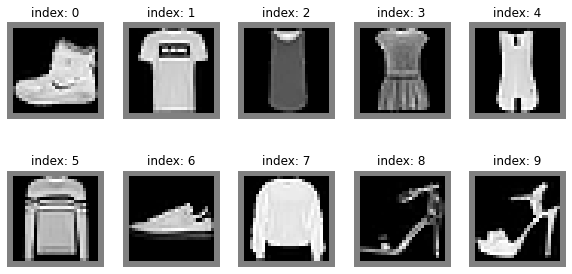

In [3]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i].reshape(32, 32), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [4]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 8:   # Bag:8
            new_t_labels.append([0])  # Bag을 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [5]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [6]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [7]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(54000, 32, 32, 1) (54000, 1)
(6000, 32, 32, 1) (6000, 1)


In [8]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [9]:
print(train_data.shape)
print(test_data.shape)

(54000, 32, 32, 1)
(16000, 32, 32, 1)


In [10]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(54000, 1)
(16000, 1)


In [11]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [14]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]], shape=(8, 1), dtype=int64)


In [15]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [16]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [17]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

In [18]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

In [19]:
generator = Generator(num_output_channel=1)  # Generator가 32X32X1 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

In [20]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [21]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [22]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [23]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

In [24]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [25]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
max_epochs = 5
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 30.37959861755371, 	 Total Dis Loss : 0.0015587876550853252
Steps : 200, 	 Total Gen Loss : 30.332420349121094, 	 Total Dis Loss : 0.003452947363257408
Steps : 300, 	 Total Gen Loss : 29.90044593811035, 	 Total Dis Loss : 0.0003504113119561225
Steps : 400, 	 Total Gen Loss : 30.034093856811523, 	 Total Dis Loss : 0.0004987683496437967
Steps : 500, 	 Total Gen Loss : 31.128765106201172, 	 Total Dis Loss : 4.926184919895604e-05
Steps : 600, 	 Total Gen Loss : 28.205957412719727, 	 Total Dis Loss : 0.0006169606349430978
Steps : 700, 	 Total Gen Loss : 30.47907829284668, 	 Total Dis Loss : 0.00026139229885302484
Steps : 800, 	 Total Gen Loss : 30.661102294921875, 	 Total Dis Loss : 9.76066367002204e-05
Steps : 900, 	 Total Gen Loss : 31.167226791381836, 	 Total Dis Loss : 0.0015922600869089365
Steps : 1000, 	 Total Gen Loss : 30.250551223754883, 	 Total Dis Loss : 0.0008385974797420204
Steps : 1100, 	 Total Gen Loss : 27.18029022216797, 	 Total Dis Loss : 0.

Steps : 8900, 	 Total Gen Loss : 30.512435913085938, 	 Total Dis Loss : 0.002702775876969099
Steps : 9000, 	 Total Gen Loss : 31.003610610961914, 	 Total Dis Loss : 0.0011082467390224338
Steps : 9100, 	 Total Gen Loss : 32.6804313659668, 	 Total Dis Loss : 0.010673555545508862
Steps : 9200, 	 Total Gen Loss : 31.426454544067383, 	 Total Dis Loss : 0.0011484276037663221
Steps : 9300, 	 Total Gen Loss : 30.953262329101562, 	 Total Dis Loss : 0.0016151982126757503
Steps : 9400, 	 Total Gen Loss : 33.10356521606445, 	 Total Dis Loss : 0.0015854556113481522
Steps : 9500, 	 Total Gen Loss : 31.494014739990234, 	 Total Dis Loss : 0.003380544250831008
Steps : 9600, 	 Total Gen Loss : 30.551239013671875, 	 Total Dis Loss : 0.4987736940383911
Steps : 9700, 	 Total Gen Loss : 29.30673599243164, 	 Total Dis Loss : 0.003581955563277006
Steps : 9800, 	 Total Gen Loss : 29.60118865966797, 	 Total Dis Loss : 0.0073826927691698074
Steps : 9900, 	 Total Gen Loss : 31.713333129882812, 	 Total Dis Loss : 

Steps : 17600, 	 Total Gen Loss : 33.64118194580078, 	 Total Dis Loss : 0.000619197846390307
Steps : 17700, 	 Total Gen Loss : 33.0833740234375, 	 Total Dis Loss : 0.0004977376665920019
Steps : 17800, 	 Total Gen Loss : 33.34765625, 	 Total Dis Loss : 0.00020299605967011303
Steps : 17900, 	 Total Gen Loss : 34.220550537109375, 	 Total Dis Loss : 0.00015708488353993744
Steps : 18000, 	 Total Gen Loss : 30.576940536499023, 	 Total Dis Loss : 0.002053576521575451
Steps : 18100, 	 Total Gen Loss : 33.34306335449219, 	 Total Dis Loss : 0.0003183399676345289
Steps : 18200, 	 Total Gen Loss : 30.510961532592773, 	 Total Dis Loss : 0.00024368250160478055
Steps : 18300, 	 Total Gen Loss : 31.188495635986328, 	 Total Dis Loss : 0.0034905087668448687
Steps : 18400, 	 Total Gen Loss : 28.313634872436523, 	 Total Dis Loss : 0.001223771134391427
Steps : 18500, 	 Total Gen Loss : 34.355037689208984, 	 Total Dis Loss : 0.0006141242920421064
Steps : 18600, 	 Total Gen Loss : 31.87984275817871, 	 Total 

Steps : 26300, 	 Total Gen Loss : 34.4869270324707, 	 Total Dis Loss : 0.00026440160581842065
Steps : 26400, 	 Total Gen Loss : 31.448965072631836, 	 Total Dis Loss : 0.0021524387411773205
Steps : 26500, 	 Total Gen Loss : 30.674741744995117, 	 Total Dis Loss : 0.001356750726699829
Steps : 26600, 	 Total Gen Loss : 36.5028190612793, 	 Total Dis Loss : 0.0001673072256380692
Steps : 26700, 	 Total Gen Loss : 32.75950241088867, 	 Total Dis Loss : 0.0009160332265309989
Steps : 26800, 	 Total Gen Loss : 31.204092025756836, 	 Total Dis Loss : 0.0010738573037087917
Steps : 26900, 	 Total Gen Loss : 32.69697952270508, 	 Total Dis Loss : 0.00020433431200217456
Steps : 27000, 	 Total Gen Loss : 32.84028625488281, 	 Total Dis Loss : 0.00045467138988897204
Time for epoch 4 is 416.6502101421356 sec
Steps : 27100, 	 Total Gen Loss : 32.694454193115234, 	 Total Dis Loss : 0.000487496901769191
Steps : 27200, 	 Total Gen Loss : 33.57573699951172, 	 Total Dis Loss : 0.000326937937643379
Steps : 27300, 	

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [32]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [33]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

16000 16000


In [34]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(7000,)


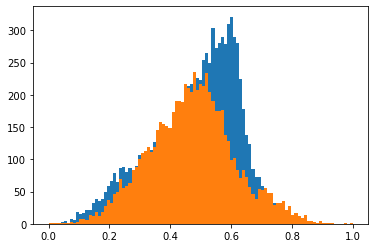

In [35]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.4865234 0.47190255
0.1448972 0.14040434


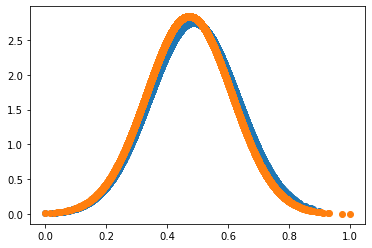

In [36]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

- 이상감지용 데이터셋 구축 (개구리 데이터를 학습데이터셋에서 제외하여 테스트 데이터셋에 포함)
- Skip-GANomaly 모델의 구현
- 모델의 학습과 검증
- 검증 결과의 시각화 (정상-이상 데이터의 anomaly score 분포 시각화, 적절한 threshold에 따른 이삼감지율 계-산, 감지 성공/실패사례 시각화 포함)